In [2]:
import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import multiprocessing as mp

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import time
import scipy

import skyplot_tools as spt
from corner import corner

from astropy.time import Time
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from enterprise.pulsar import Pulsar

from la_forge.core import Core
from la_forge.diagnostics import plot_chains

nano11_pkl = '/home/nima/nanograv/11yr_factlike/NANOGrav_11yr_DE436.pickle'
with open(nano11_pkl, 'rb') as f:
    allpsrs=pickle.load(f)

In [3]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.98)}

plt.rcParams.update(params)

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


# Resample from Charts

In [5]:
chartdir= '/home/nima/nanograv/11yr_factlike/ULvSky_charts/'

charts=os.listdir(chartdir)

print(sorted(charts))
print(len(charts))

['0_0.txt', '0_1.txt', '0_2.txt', '0_3.txt', '0_4.txt', '0_5.txt', '0_6.txt', '0_7.txt', '100_0.txt', '100_1.txt', '100_2.txt', '100_3.txt', '100_4.txt', '100_5.txt', '100_6.txt', '100_7.txt', '101_0.txt', '101_1.txt', '101_2.txt', '101_3.txt', '101_4.txt', '101_5.txt', '101_6.txt', '101_7.txt', '102_0.txt', '102_1.txt', '102_2.txt', '102_3.txt', '102_4.txt', '102_5.txt', '102_6.txt', '102_7.txt', '103_0.txt', '103_1.txt', '103_2.txt', '103_3.txt', '103_4.txt', '103_5.txt', '103_6.txt', '103_7.txt', '104_0.txt', '104_1.txt', '104_2.txt', '104_3.txt', '104_4.txt', '104_5.txt', '104_6.txt', '104_7.txt', '105_0.txt', '105_1.txt', '105_2.txt', '105_3.txt', '105_4.txt', '105_5.txt', '105_6.txt', '105_7.txt', '106_0.txt', '106_1.txt', '106_2.txt', '106_3.txt', '106_4.txt', '106_5.txt', '106_6.txt', '106_7.txt', '107_0.txt', '107_1.txt', '107_2.txt', '107_3.txt', '107_4.txt', '107_5.txt', '107_6.txt', '107_7.txt', '108_0.txt', '108_1.txt', '108_2.txt', '108_3.txt', '108_4.txt', '108_5.txt', '

In [6]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights)
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)

        
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

In [7]:
import multiprocessing as mp
def resample_worker(skypix):
    chartdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/final_run/fullsky_charts/'
    skypix_hist_outdir = '/home/nima/nanograv/11yr_burst_factorizedlikelihood/final_run/skypix_hists/'

    outf = skypix_hist_outdir + "{}_hist.txt".format(skypix)
    os.makedirs(skypix_hist_outdir, exist_ok=True)
    
    amps=np.logspace(-17, -10, 70)

    # set up the sensitive burst epochs. we only want the last 3 years. Since we have 1 point for each month,
    # we just need the last 36 epochs.
   
 
    nano11_Ts = np.linspace(53216.13175403874+180,57387.78760427694-180, 134, endpoint=True)

    min_idx = np.argmin(np.abs(nano11_Ts - 56000))
    max_idx = np.argmin(np.abs(nano11_Ts - 57000))
    
    cols=np.arange(min_idx, max_idx)
    
    pols = np.linspace(0, np.pi, 8)

    
    # for the skypixel runs, we just want to marginalize over polarizations
    # start by marginalizing each of the polarization charts over 
    polarization_dict = {}
    for pol_idx, pol in enumerate(pols):
        this_pol_amp_logposts = np.zeros(len(amps))
        this_pol_chart = np.loadtxt(chartdir + "{}_{}.txt".format(skypix, pol_idx))
        for amp_idx, amp in enumerate(amps):
            # get max for this row
            chartmax = np.amax(this_pol_chart[amp_idx, cols[0]:cols[-1]])
    
            #marginalize over t0
            this_amp_post = 0
            for t0_idx in cols:
                this_amp_post += np.exp(this_pol_chart[amp_idx, t0_idx] - chartmax)
            this_amp_logpost = np.log(this_amp_post) + chartmax
            this_pol_amp_logposts[amp_idx] = this_amp_logpost
            
        polarization_dict[pol_idx] = this_pol_amp_logposts
    # Now polarization_dict is populated with the amplitude logposterior for each polarization bin
    # just need to marginalize over polarization now
    
    final_amp_logposts = np.zeros(len(amps))
    for amp_idx, amp in enumerate(amps):
        total_amp_post = 0
        before_combine = [polarization_dict[pidx][amp_idx] for pidx in polarization_dict]
        reduc_factor = np.amax(before_combine)
        
        #marginalize over the polarization bins
        for idx, val in enumerate(before_combine):
            total_amp_post += np.exp(val - reduc_factor)
        
        #record
        final_amp_logposts[amp_idx] = np.log(total_amp_post) + reduc_factor
        
    # Now we have the final amplitude logposterior and need to resample it.
    # let's rewrite things in terms of weights and centers
    centers=amps
    normalization = np.amax(final_amp_logposts)
    weights = np.exp(final_amp_logposts-normalization)
    for amp_idx, amp in enumerate(amps):
        weights[amp_idx] *= 10**(amp) #factor for uniform bit
    
    #sample
    start=time.time()
    print("starting sampling for {}".format(skypix))
    this_skypix_hist = sample_hist(weights, centers, num_points=500, sample_bounds=None, verbose=False)
    # Now this skypix has samples from each polarization bin. Let's save it.
    print("Completed skypix {} in {} seconds".format(skypix, time.time()-start))
    np.savetxt(outf, this_skypix_hist)

In [ ]:
# nside=8
# npix = hp.nside2npix(nside)
# skypixes = np.arange(npix)

# p = mp.Pool(processes=15)
# p.map(resample_worker, skypixes)

# Load and plot


In [8]:
skypix_histdir = '/home/nima/nanograv/11yr_factlike/skypix_hists/'
nside = 8
npix = hp.nside2npix(nside)

UL_skymap = np.zeros(npix)

for skypix in range(npix):
    skypix_hist = sorted(np.loadtxt(skypix_histdir + "{}_hist.txt".format(skypix)))
    idx_95 = int(0.95 * len(skypix_hist))
    UL_skymap[skypix] = skypix_hist[idx_95]

In [9]:
nano11_psrlocs = []
for p in allpsrs:
    ## locations are given in [phi, costheta]
    theta, phi = hp.vec2ang(p.pos)
    psrloc = [phi[0], np.cos(theta[0])]

    nano11_psrlocs.append(psrloc)
nano11_psrlocs = np.array(nano11_psrlocs)


min = 9.68e-15; max = 1.17e-13


/home/nima/nanograv/11yr_factlike/skyplot_tools.py:498: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis_r").copy()
  aximg.cmap.set_bad('w', alpha=0.)


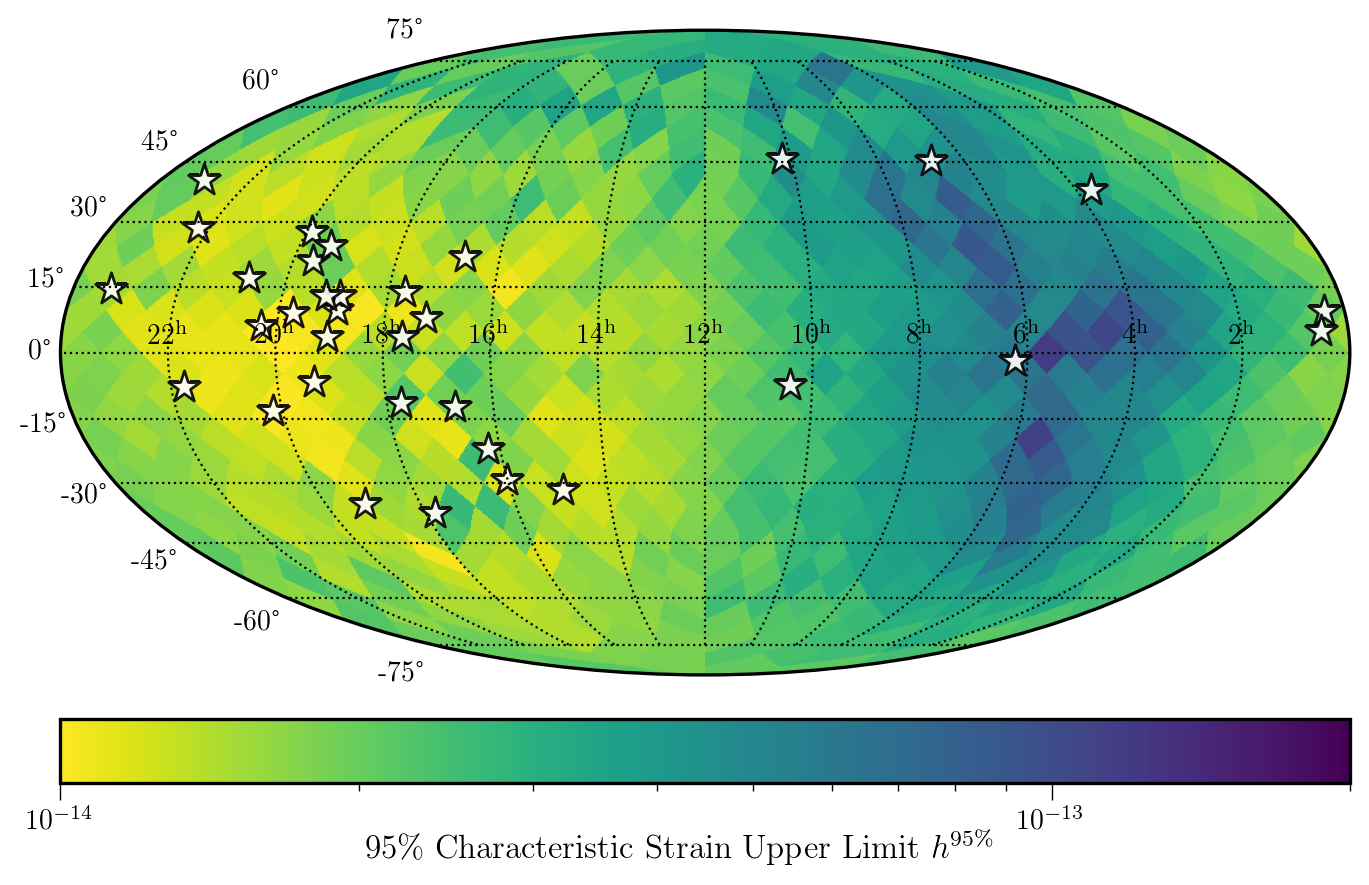

In [11]:
print("min = {:.2e}; max = {:.2e}".format(min(UL_skymap), max(UL_skymap)))

zmin = 1e-14
zmax = 2e-13
skymap_exp = 10**UL_skymap
norm=LogNorm(vmin=zmin, vmax=zmax)

plt.close('all')
plt.figure(0, figsize=(7, 5))
ax = plt.subplot(111, projection='astro mollweide', )
ax.grid()
#spt.outline_text(ax)

spt.healpix_heatmap(UL_skymap, cmap='viridis_r', norm=LogNorm(vmin=zmin, vmax=zmax),)

ax.scatter(nano11_psrlocs[:,0], nano11_psrlocs[:,1], 12**2,
          marker='*', facecolor='w', edgecolors='k', alpha=0.9)

cbar = plt.colorbar(orientation='horizontal', pad=0.05)
plt.suptitle('95\% Characteristic Strain Upper Limit $h^{95\%}$', y=0.05)
plt.grid(linestyle='dotted', color='k')
plt.tight_layout()
plt.show()

min = 1.09e-14; max = 1.12e-13


/home/nima/nanograv/11yr_factlike/skyplot_tools.py:498: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bwr").copy()
  aximg.cmap.set_bad('w', alpha=0.)


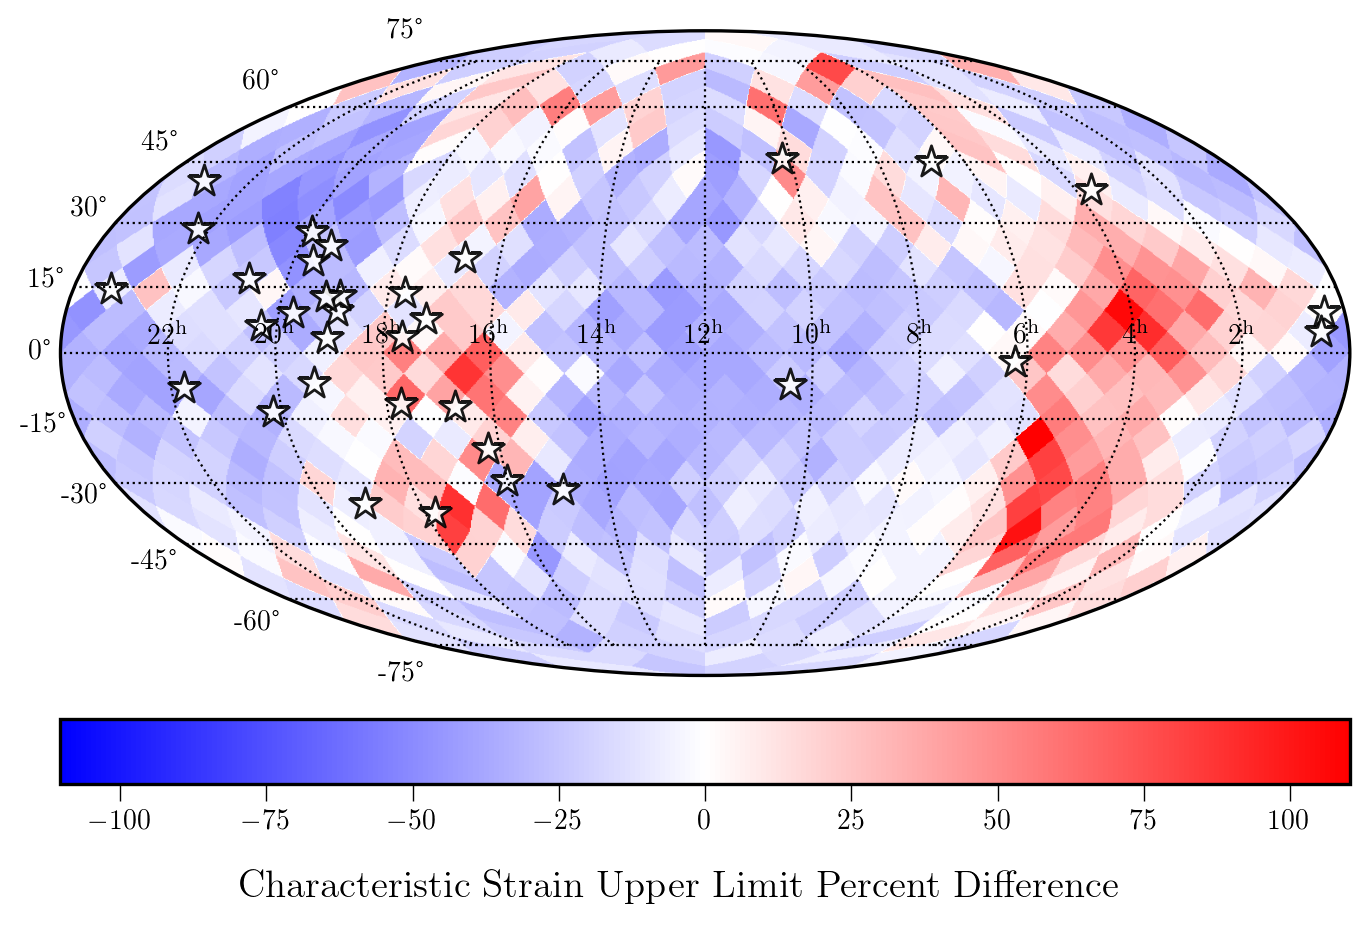

In [17]:
rundir = '/home/nima/nanograv/11yr/postproc_nb/11yr_bwm_paper_data/'
run, skymap, Ns, cors = np.loadtxt(rundir+'skymap_ULs.dat').T

print("min = {:.2e}; max = {:.2e}".format(min(10**skymap), max(10**skymap)))


nano11_skymap_exp = 10**skymap

plt.close('all')
plt.figure(0, figsize=(7, 5))
ax = plt.subplot(111, projection='astro mollweide')
ax.grid()
#spt.outline_text(ax)

pct_diff = np.zeros(len(UL_skymap))
for ii, el in enumerate(pct_diff):
    pct_diff[ii] = (UL_skymap[ii] - nano11_skymap_exp[ii])/nano11_skymap_exp[ii] * 100

bounds = max(np.abs(max(pct_diff)), np.abs(min(pct_diff)))
# vmax = 70
# vmin = -70
vmax = np.abs(bounds)
vmin = -1 * vmax

norm=Normalize(vmin=vmin, vmax=vmax)
    
spt.healpix_heatmap(pct_diff, cmap='bwr', norm=norm)

ax.scatter(nano11_psrlocs[:,0], nano11_psrlocs[:,1], 12**2,
          marker='*', facecolor='w', edgecolors='k', alpha=0.9)

cbar = plt.colorbar(orientation='horizontal', pad=0.05, label='% difference (blue means improvement)')
plt.suptitle('Characteristic Strain Upper Limit Percent Difference', y=0.01, fontweight='heavy', fontsize=14,)
plt.grid(linestyle='dotted', color='k')
plt.tight_layout()
plt.show()